In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
import itertools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import pathlib
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams.update({'font.size': 10 * 2.54})
mpl.rcParams['text.latex.preamble']=r"\usepackage{bm}\usepackage{amsmath}"
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp
import diffrax

In [4]:
import exciting_environments as excenvs

from dmpe.utils.density_estimation import select_bandwidth
from dmpe.utils.signals import aprbs
from dmpe.models import NeuralEulerODE
from dmpe.algorithms import excite_with_dmpe
from dmpe.related_work.algorithms import excite_with_sGOATS
from dmpe.utils.density_estimation import DensityEstimate, build_grid
from dmpe.evaluation.experiment_utils import (
    get_experiment_ids, load_experiment_results, quick_eval, evaluate_experiment_metrics, evaluate_algorithm_metrics, evaluate_metrics
)

2025-03-09 14:03:44.482661: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
import dmpe.utils.env_utils.pmsm_utils as pmsm_utils
from dmpe.utils.env_utils.pmsm_utils import plot_constraints_induced_voltage, plot_sequence_with_constraints

In [6]:
full_column_width = 18.2
half_column_width = 8.89

# Qualitative plots specifically to show different behavior for different rpm

In [7]:
def get_physical_i_dq(x, env):
    """Transform the normalized state to physical currents."""

    i_d_normalizer = env.env_properties.physical_normalizations.i_d
    i_q_normalizer = env.env_properties.physical_normalizations.i_q

    if x.ndim > 1:
        physical_grid_i_d = jax.vmap(i_d_normalizer.denormalize)(x[..., 0])
        physical_grid_i_q = jax.vmap(i_q_normalizer.denormalize)(x[..., 1])
    else:
        physical_grid_i_d = i_d_normalizer.denormalize(x[0])
        physical_grid_i_q = i_q_normalizer.denormalize(x[1])
    physical_i_dq = jnp.stack([physical_grid_i_d, physical_grid_i_q], axis=-1)
    
    return physical_i_dq
    

def get_induced_voltages(physical_i_dq, env, w_el):
    """Get the induced voltage value for a single grid point. Needs to be vmapped along the grid for multidimensional inputs!"""

    p = env.env_properties.static_params.p
    r_s = env.env_properties.static_params.r_s
    psi_p = env.env_properties.static_params.psi_p

    psid = env.LUT_interpolators['Psi_d'](physical_i_dq)
    psiq = env.LUT_interpolators['Psi_q'](physical_i_dq)

    if physical_i_dq.ndim > 1:
        physical_i_d = physical_i_dq[..., 0]
        physical_i_q = physical_i_dq[..., 1]
    else:
        physical_i_d = physical_i_dq[0]
        physical_i_q = physical_i_dq[1]
    

    ud = r_s * physical_i_d - w_el * psiq
    uq = r_s * physical_i_q + w_el * psid

    U = jnp.sqrt(ud**2 + uq**2)

    return U

def plot_constraints_induced_voltage_qualitative_results(fig, axs, plot_idx, x_g, env, show_torque=False, u_max=400/jnp.sqrt(3), i_max=250):
    """Plot the constraints onto the currents due to the induced voltage."""

    _, state = env.reset(env.env_properties)
    w_el = state.physical_state.omega_el
    
    physical_i_dq = get_physical_i_dq(x_g, env)

    points_per_dim = int(jnp.sqrt(x_g.shape[0]))
    
    U_map = get_induced_voltages(physical_i_dq, env, w_el).reshape(points_per_dim, points_per_dim)
        
    i_d_plot = physical_i_dq[..., 0].reshape(points_per_dim, points_per_dim)
    i_q_plot = physical_i_dq[..., 1].reshape(points_per_dim, points_per_dim)
    
    I_map = np.sqrt(i_d_plot**2 + i_q_plot**2)
    
    axs[plot_idx].contour(i_d_plot, i_q_plot, I_map, levels=[i_max], colors="k", linewidths=1.5)
    axs[plot_idx].contour(i_d_plot, i_q_plot, U_map, levels=[u_max], colors="k", linewidths=1.5)
    axs[plot_idx].set_ylim(-300, 300)
    axs[plot_idx].set_xlim((-300, 50))

    return fig, axs

def setup_env(rpm):
    env = pmsm_utils.ExcitingPMSM(
        initial_rpm=rpm,
        batch_size=1,
        saturated=True,
        LUT_motor_name="BRUSA",
        static_params={
            "p": 3,
            "r_s": 17.932e-3,
            "l_d": jnp.nan,
            "l_q": jnp.nan,
            "psi_p": 65.65e-3,
            "deadtime": 0,
        },
        solver=diffrax.Tsit5(),
    )
    penalty_function = lambda observations, actions: pmsm_utils.PMSM_penalty(env, observations, actions)

    return env, penalty_function

#### scatter:

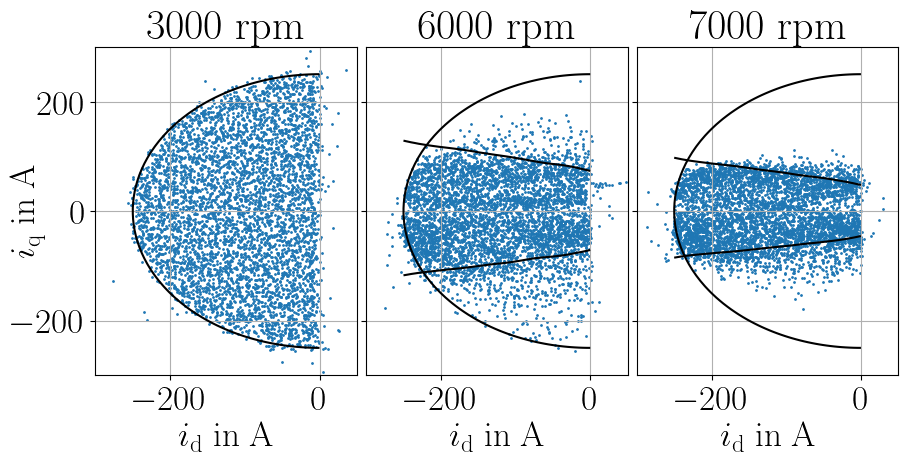

In [12]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/NODE/")
node_file_names = [
    'rpm_3000.0_ca_False_2025-03-08_16:37:35',
    'rpm_6000.0_ca_False_2025-03-08_17:19:32',
    'rpm_7000.0_ca_False_2025-03-08_17:39:57',
]


fig, axs = plt.subplots(1,3, figsize=(half_column_width, half_column_width/2), sharey=True)

for ax in axs:
    ax.grid(True)
    ax.set_xlabel(r"$i_\mathrm{d} \; \mathrm{in} \; \mathrm{A}$")
axs[0].set_ylabel(r"$i_\mathrm{q} \; \mathrm{in} \; \mathrm{A}$", labelpad=-25)

x_g = build_grid(
    2,
    low=-1.0,
    high=1.0,
    points_per_dim=50
)

for plot_idx, file_name in enumerate(node_file_names):

    params, observations, actions, _ = load_experiment_results(file_name, results_path, None)

    rpm = int(params["rpm"])
    env, _ = setup_env(rpm)
    
    axs[plot_idx].set_title(fr"${rpm}$" + r"$ \; \mathrm{rpm}$")
    
    fig, axs = plot_constraints_induced_voltage_qualitative_results(fig, axs, plot_idx, x_g, env)
    physical_i_dq = get_physical_i_dq(observations, env)
    axs[plot_idx].scatter(physical_i_dq[..., 0], physical_i_dq[..., 1], s=1)

fig.tight_layout(pad=0.01)
plt.savefig("results/qualitative/qualitative_node_scatter.png", dpi=200)
plt.show()

#### density:

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/NODE/")
node_file_names = [
    'rpm_3000.0_ca_False_2025-03-04_19:21:03',
    'rpm_6000.0_ca_False_2025-03-04_20:39:30',
    'rpm_8000.0_ca_False_2025-03-04_21:58:14',
]


fig, axs = plt.subplots(1,3, figsize=(full_column_width, half_column_width), sharey=True)

for ax in axs:
    ax.grid(True)
    ax.set_xlabel(r"$i_\mathrm{d} \; \mathrm{in} \; \mathrm{A}$")
axs[0].set_ylabel(r"$i_\mathrm{q} \; \mathrm{in} \; \mathrm{A}$")

x_g = build_grid(
    2,
    low=-1.0,
    high=1.0,
    points_per_dim=50
)

for plot_idx, file_name in enumerate(node_file_names):

    params, observations, actions, _ = load_experiment_results(file_name, results_path, None)

    rpm = int(params["rpm"])
    env, _ = setup_env(rpm)
    
    axs[plot_idx].set_title(fr"${rpm}$" + r"$ \; \mathrm{rpm}$")
    
    fig, axs = plot_constraints_induced_voltage_qualitative_results(fig, axs, plot_idx, x_g, env)
    physical_i_dq = get_physical_i_dq(observations, env)


    density_estimate = DensityEstimate.from_dataset(
        observations[None], 
        points_per_dim=50, 
        x_min=-1.05,
        x_max=1.05,
        bandwidth=0.08
    )

    raise NotImplementedError
    
    axs[plot_idx].contourf(
        
    )

# fig.tight_layout()
# plt.savefig("results/pmsm/qualitative_node_dist.png", dpi=200)
# plt.show()

---

# Qualitative Plots to show transients in NODE approach

- comparison with RLS?

In [13]:
from dmpe.evaluation.plotting_utils import plot_sequence
from dmpe.utils.env_utils.pmsm_utils import plot_current_constraints

In [63]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/NODE/")
file_name = 'rpm_6000.0_ca_False_2025-03-08_17:19:32'

# results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/NODE/")
# file_name = 'rpm_2000.0_ca_False_2025-03-08_15:47:31'

params, observations, actions, _ = load_experiment_results(file_name, results_path, None)

rpm = int(params["rpm"])
env, _ = setup_env(rpm)

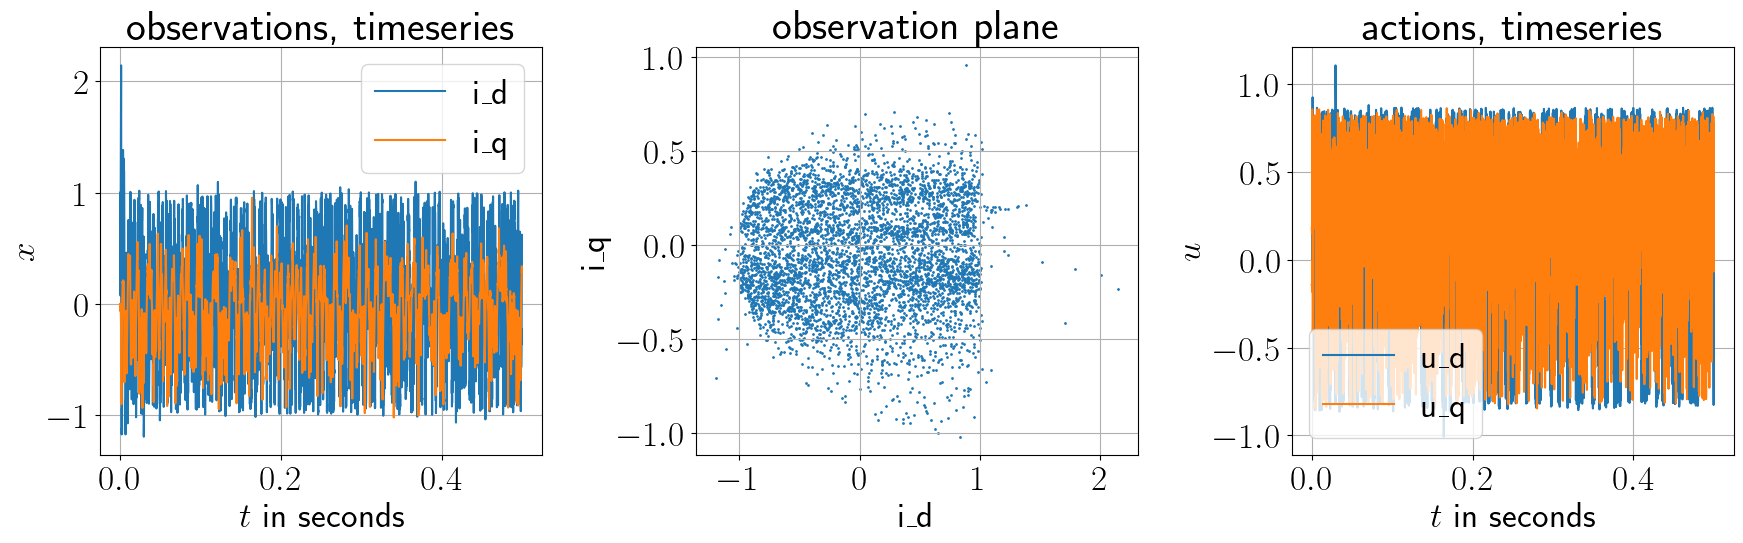

In [64]:
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=env.tau,
    obs_labels=["i_d", "i_q"],
    action_labels=["u_d", "u_q"]
)


In [65]:
# show transient behavior
# also show eigenbehavior of the system here?

In [66]:
def eigendynamics_vector_field(i_dq, env):

    obs, test_state = env.reset(env.env_properties)
    omega_el = test_state.physical_state.omega_el
    
    i_d, i_q = i_dq
    u_dq = jnp.zeros(2)

    J_k = jnp.array([[0, -1], [1, 0]])
    i_dq = jnp.array([i_d, i_q])
    p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in env.LUT_interpolators.items()}
    L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
    L_diff_inv = jnp.linalg.inv(L_diff)
    psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
    di_dq_1 = jnp.einsum(
        "ij,j->i",
        (-L_diff_inv * env.env_properties.static_params.r_s),
        i_dq,
    )
    di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
    di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
    i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
    d_y = i_dq_diff[0], i_dq_diff[1]
    return jnp.hstack(d_y)

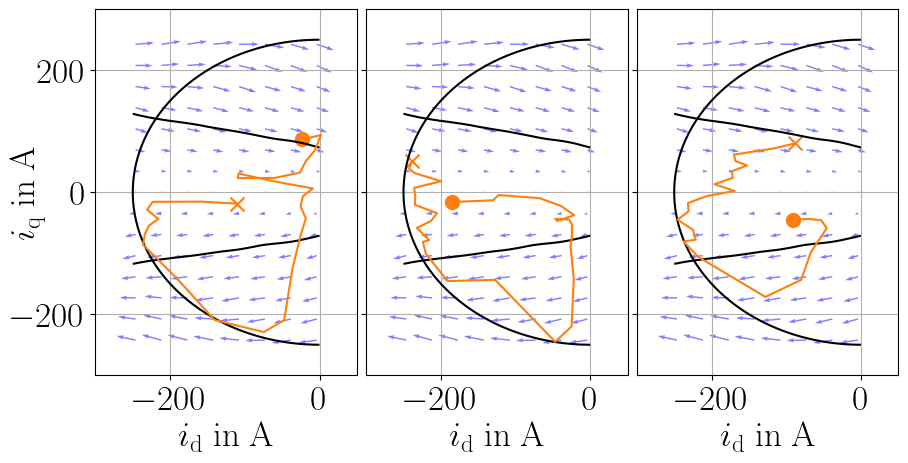

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(half_column_width, half_column_width/2), sharey=True)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel(r"$i_\mathrm{d} \; \mathrm{in} \; \mathrm{A}$")
axs[0].set_ylabel(r"$i_\mathrm{q} \; \mathrm{in} \; \mathrm{A}$", labelpad=-25)


for plot_idx, plot_range in enumerate([(570, 598), (3030, 3060), (4973, 4997)]):

    colors = list(plt.rcParams["axes.prop_cycle"])[: observations.shape[-1]]
    
    #### quiver plot
    
    x_g = build_grid(
        2,
        low=-0.97,
        high=0.97,
        points_per_dim=15
    )
    
    physical_i_dq_grid = get_physical_i_dq(x_g, env)

    points_per_dim = jnp.sqrt(x_g.shape[0])
    physical_i_dq_grid = physical_i_dq_grid.reshape(int(points_per_dim.item()), int(points_per_dim.item()), 2)[:, ::2, ...].reshape(-1, 2)
    
    didt_map = jax.vmap(eigendynamics_vector_field, in_axes=(0, None))(physical_i_dq_grid, env)
    
    x, y = physical_i_dq_grid[:, 0], physical_i_dq_grid[:, 1]
    
    u, v = didt_map[:, 0], didt_map[:, 1]
  
    
    axs[plot_idx].quiver(x, y, u, v, scale=None, color='b', alpha=0.5)
    
    ### plot constraints 
    
    x_g = build_grid(
        2,
        low=-1.0,
        high=1.0,
        points_per_dim=50
    )
    
    fig, axs = plot_constraints_induced_voltage_qualitative_results(fig, axs, plot_idx, x_g, env, u_max=400 / jnp.sqrt(3))


    ### plot transient trajectory
    
    physical_i_dq = get_physical_i_dq(observations, env)
    axs[plot_idx].plot(
        physical_i_dq[plot_range[0]:plot_range[1], 0],
        physical_i_dq[plot_range[0]:plot_range[1], 1],
        colors[1]["color"],
    )
    start_point = physical_i_dq[plot_range[0]:plot_range[1]][0]
    end_point = physical_i_dq[plot_range[0]:plot_range[1]][-1]

    axs[plot_idx].scatter(*start_point, color=colors[1]["color"], marker="o", s=100, label="Start")  # Start point in green
    axs[plot_idx].scatter(*end_point, color=colors[1]["color"], marker="x", s=100, label="End")  # End point in red


for ax in axs:
    ax.set_ylim(-300, 300)
    ax.set_xlim(-300, 50)

fig.tight_layout(pad=0.01)
plt.savefig("results/qualitative/transients_in_detail.png", dpi=200)
plt.show()

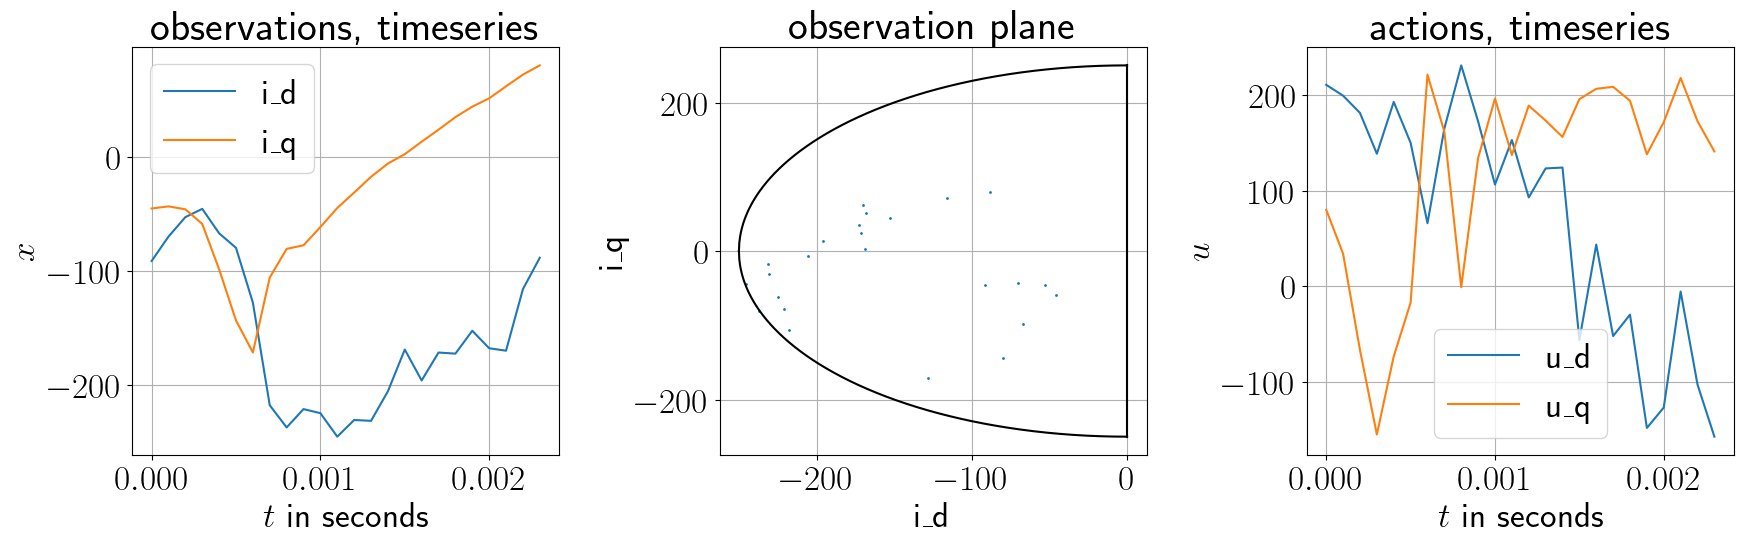

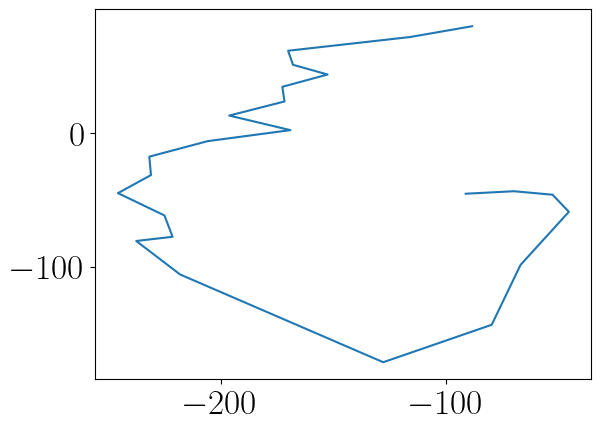

In [55]:
plot_range=(4973, 4997)

physical_i_dq = get_physical_i_dq(observations, env)

fig, axs = plot_sequence(
    observations=physical_i_dq[plot_range[0]:plot_range[1]],
    actions=jnp.vstack([
        env.env_properties.action_normalizations.u_d.denormalize(actions[plot_range[0]:plot_range[1], 0]),
        env.env_properties.action_normalizations.u_q.denormalize(actions[plot_range[0]:plot_range[1], 1])
    ]).T,
    tau=env.tau,
    obs_labels=["i_d", "i_q"],
    action_labels=["u_d", "u_q"]
)


i_d_normalizer = env.env_properties.physical_normalizations.i_d
i_q_normalizer = env.env_properties.physical_normalizations.i_q
plot_current_constraints(fig, axs[1], i_d_normalizer, i_q_normalizer)

plt.show()

plt.plot(physical_i_dq[plot_range[0]:plot_range[1], 0], physical_i_dq[plot_range[0]:plot_range[1], 1])

# Qualitative Comparison between NODE, RLS, PM and iGOATS:

In [ ]:
# TODO

---

In [ ]:
#for file_name in get_experiment_ids(results_path):
for file_name in [
    'rpm_3000.0_ca_False_2025-03-04_19:21:03',
    
    'rpm_8000.0_ca_False_2025-03-04_21:58:14',
]:

    params, observations, actions, _ = load_experiment_results(file_name, results_path, None)
        
    env = pmsm_utils.ExcitingPMSM(
        initial_rpm=params["rpm"],
        batch_size=1,
        saturated=True,
        LUT_motor_name="BRUSA",
        static_params={
            "p": 3,
            "r_s": 17.932e-3,
            "l_d": jnp.nan,
            "l_q": jnp.nan,
            "psi_p": 65.65e-3,
            "deadtime": 0,
        },
        solver=diffrax.Tsit5(),
    )
    
    _, state = env.reset(env.env_properties)
    i_d_normalizer = env.env_properties.physical_normalizations.i_d
    i_q_normalizer = env.env_properties.physical_normalizations.i_q
    
    physical_i_d = i_d_normalizer.denormalize(observations[..., 0])
    physical_i_q = i_q_normalizer.denormalize(observations[..., 1])
    
    print(state.physical_state.omega_el)
    
    
    plot_constraints_induced_voltage_qualitative_results(env, physical_i_d, physical_i_q, w_el=state.physical_state.omega_el, saturated=True, show_torque=False)
    # plt.savefig(str(params["rpm"]) + "_rpm.png")
    plt.show()

# Misc stuff:

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/PM/")
get_experiment_ids(results_path)

In [ ]:
for file_name in get_experiment_ids(results_path):

    if "False" in file_name:
        continue
    
    params, observations, actions, _ = load_experiment_results(file_name, results_path, None)
        
    env = pmsm_utils.ExcitingPMSM(
        initial_rpm=params["rpm"],
        batch_size=1,
        saturated=True,
        LUT_motor_name="BRUSA",
        static_params={
            "p": 3,
            "r_s": 17.932e-3,
            "l_d": jnp.nan,
            "l_q": jnp.nan,
            "psi_p": 65.65e-3,
            "deadtime": 0,
        },
        solver=diffrax.Tsit5(),
    )
    
    _, state = env.reset(env.env_properties)
    i_d_normalizer = env.env_properties.physical_normalizations.i_d
    i_q_normalizer = env.env_properties.physical_normalizations.i_q
    
    physical_i_d = i_d_normalizer.denormalize(observations[..., 0])
    physical_i_q = i_q_normalizer.denormalize(observations[..., 1])
    
    print(state.physical_state.omega_el)
    
    
    plot_constraints_induced_voltage(env, physical_i_d, physical_i_q, w_el=state.physical_state.omega_el, saturated=True, show_torque=False)
    # plt.savefig(str(params["rpm"]) + "_rpm.png")
    plt.show()

In [ ]:
# for i in range(1, 12):
#     print(state.physical_state.omega_el * i)
#     fig = plot_constraints_induced_voltage(env, physical_i_d, physical_i_q, w_el=state.physical_state.omega_el * i, saturated=True, show_torque=False)
#     plt.show()

In [ ]:
file_name = 'rpm_5000.0_ca_False_2025-03-04_16:48:27'

params, observations, actions, _ = load_experiment_results(file_name, results_path, None)
    
env = pmsm_utils.ExcitingPMSM(
    initial_rpm=params["rpm"],
    batch_size=1,
    saturated=True,
    LUT_motor_name="BRUSA",
    static_params={
        "p": 3,
        "r_s": 17.932e-3,
        "l_d": jnp.nan,
        "l_q": jnp.nan,
        "psi_p": 65.65e-3,
        "deadtime": 0,
    },
    solver=diffrax.Tsit5(),
)

_, state = env.reset(env.env_properties)
i_d_normalizer = env.env_properties.physical_normalizations.i_d
i_q_normalizer = env.env_properties.physical_normalizations.i_q

physical_i_d = i_d_normalizer.denormalize(observations[..., 0])
physical_i_q = i_q_normalizer.denormalize(observations[..., 1])

print(state.physical_state.omega_el)


plot_constraints_induced_voltage(env, physical_i_d, physical_i_q, w_el=state.physical_state.omega_el, saturated=True)
plt.savefig(str(params["rpm"]) + "_rpm.png")

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/scripts/pmsm/results/dmpe/RLS/")

for file_name in [
    'rpm_2000.0_ca_False_2025-03-03_17:53:21',
    'rpm_5000.0_ca_False_2025-03-03_18:02:16',
    'rpm_11000.0_ca_False_2025-03-03_18:15:25',
]:
    params, observations, actions, _ = load_experiment_results(file_name, results_path, None)
    
    env = pmsm_utils.ExcitingPMSM(
        initial_rpm=params["rpm"],
        batch_size=1,
        saturated=True,
        LUT_motor_name="BRUSA",
        static_params={
            "p": 3,
            "r_s": 17.932e-3,
            "l_d": jnp.nan,
            "l_q": jnp.nan,
            "psi_p": 65.65e-3,
            "deadtime": 0,
        },
        solver=diffrax.Tsit5(),
    )
    
    _, state = env.reset(env.env_properties)
    i_d_normalizer = env.env_properties.physical_normalizations.i_d
    i_q_normalizer = env.env_properties.physical_normalizations.i_q
    
    physical_i_d = i_d_normalizer.denormalize(observations[..., 0])
    physical_i_q = i_q_normalizer.denormalize(observations[..., 1])

    print(state.physical_state.omega_el)
    
    
    plot_constraints_induced_voltage(env, physical_i_d, physical_i_q, w_el=state.physical_state.omega_el, saturated=True)
    plt.savefig(str(params["rpm"]) + "_rpm.png")

---
---
---

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/results/igoats/pmsm/")

identifier = get_experiment_ids(results_path)[-1]
params, igoats_observations, igoats_actions, model = load_experiment_results(
    exp_id=identifier, results_path=results_path, model_class=None
)

In [ ]:
results_path = pathlib.Path("/home/hvater@uni-paderborn.de/projects/forks/DMPE/eval/results/dmpe/pmsm/")

identifier = get_experiment_ids(results_path)[-1]
params, dmpe_observations, dmpe_actions, model = load_experiment_results(
    exp_id=identifier, results_path=results_path, model_class=None
)


In [ ]:
# what should the qualitative plots look like?

In [ ]:
tau = 1e-4
labels=[r"$\tilde{i_d}$", r"$\tilde{i_q}$", r"$\tilde{u_d}$", r"$\tilde{u_q}$"]

full_column_width = 18.2
half_colmun_width = 8.89

In [ ]:
igoats_data = jnp.concatenate([igoats_observations, igoats_actions], axis=-1)
dmpe_data = jnp.concatenate([dmpe_observations[0:-1], dmpe_actions], axis=-1)

all_data = [dmpe_data, igoats_data]
algo_names = ["$\mathrm{DMPE}$", "$\mathrm{iGOATS}$"]

In [ ]:
# def plot_feature_combinations(all_data, labels, algo_names):

#     n_features = all_data[0].shape[-1]
#     for data in all_data:
#         assert data.shape[-1] == n_features

#     n_algos = len(all_data)    

#     all_combinations = list(itertools.combinations(np.arange(n_features), 2))
#     n_combinations = len(all_combinations)
    
#     # fig, axs = plt.subplots(nrows=n_algos, ncols=n_combinations, figsize=(full_column_width, full_column_width/3), sharex=True)
#     fig, axs = plt.subplots(nrows=n_combinations, ncols=n_algos, figsize=(full_column_width/3, full_column_width), sharey=True)
    
#     for comb_idx, (i, j) in enumerate(all_combinations):      

#         density_estimates = []
        
#         for algo_idx, (algo_name, data) in enumerate(zip(algo_names, all_data)):
#             density_estimate = DensityEstimate.from_dataset(
#                 jnp.concatenate([data[..., i][..., None], data[..., j][..., None]], axis=-1)[None],
#                 points_per_dim=100,
#                 bandwidth=0.05,
#             )
#             density_estimates.append(density_estimate)

#         stacked_p = jnp.concatenate([density_estimate.p for density_estimate in density_estimates], axis=0)
#         maximum_p_value = jnp.max(stacked_p)
#         levels = np.linspace(0, maximum_p_value, 50).round(4)

#         print(maximum_p_value)
        
#         for algo_idx, (algo_name, density_estimate) in enumerate(zip(algo_names, density_estimates)):
            
#             p_est = density_estimate.p
#             x = density_estimate.x_g

#             grid_len_per_dim = int(np.sqrt(x.shape[0]))
#             x_plot = x.reshape((grid_len_per_dim, grid_len_per_dim, 2))

#             cax = axs[comb_idx, algo_idx].contourf(
#             #cax = axs[algo_idx, comb_idx].contourf(
#                 x_plot[..., 0],
#                 x_plot[..., 1],
#                 p_est.reshape(x_plot.shape[:-1]),
#                 antialiased=False,
#                 levels=levels,
#                 alpha=1.0,
#                 cmap=plt.cm.coolwarm,
#             )
        
#             axs[comb_idx, 0].set_ylabel(labels[j])
#             axs[comb_idx, algo_idx].set_xlabel(labels[i])
#         #fig.colorbar(cax)
#     plt.subplots_adjust(hspace=0.02)
    
#     plt.tight_layout(pad=0.05)

In [ ]:
# fig = plot_feature_combinations(all_data, labels, algo_names)
# #mpl.rcParams.update({'figure.autolayout': True})

# plt.savefig("pmsm_qualitative_comparison.pdf")

In [ ]:
# from dmpe.evaluation.plotting_utils import plot_feature_combinations

In [ ]:
def get_contour_levels(all_data):
    n_levels = 50
    n_features = all_data[0].shape[-1]
    all_levels = np.zeros((n_features, n_features, n_levels)) 
    
    for i in range(n_features):
        for j in range(n_features):

            density_estimates = []
            
            for algo_idx, data in enumerate(all_data):
                density_estimate = DensityEstimate.from_dataset(
                    jnp.concatenate([data[..., i][..., None], data[..., j][..., None]], axis=-1)[None],
                    points_per_dim=100,
                    bandwidth=0.05,
                )
                density_estimates.append(density_estimate)
    
            stacked_p = jnp.concatenate([density_estimate.p for density_estimate in density_estimates], axis=0)
            maximum_p_value = jnp.max(stacked_p) + 0.03
            all_levels[i, j] =  np.linspace(0, maximum_p_value, 50)

    return all_levels

In [ ]:
all_levels = get_contour_levels([dmpe_data, igoats_data])

In [ ]:
def plot_feature_combinations(data, labels, mode="plot", all_levels=None):
    """Plot all combinations of the data set."""
    assert data.shape[-1] == len(labels)
    assert data.ndim == 2

    n_features = data.shape[-1]

    fig, axs = plt.subplots(nrows=n_features, ncols=n_features, figsize=(half_colmun_width, half_colmun_width), sharex=True, sharey=True)
    
    for i in range(n_features):
        for j in range(n_features):
            if mode == "plot":
                axs[j, i].scatter(data[..., i], data[..., j], s=0.1)
            elif mode == "contourf":
                density_estimate = DensityEstimate.from_dataset(
                    jnp.concatenate([data[..., i][..., None], data[..., j][..., None]], axis=-1)[None],
                    points_per_dim=100,
                    bandwidth=0.05,
                )

                p_est = density_estimate.p
                x = density_estimate.x_g                
                grid_len_per_dim = int(np.sqrt(x.shape[0]))
                x_plot = np.array(x.reshape((grid_len_per_dim, grid_len_per_dim, 2)))
                cax = axs[j, i].contourf(
                    x_plot[..., 0],
                    x_plot[..., 1],
                    p_est.reshape(x_plot.shape[:-1]),
                    antialiased=False,
                    levels=50 if all_levels is None else all_levels[i, j, :],
                    alpha=0.9,
                    cmap=plt.cm.coolwarm,
                )

            axs[j, 0].set_ylabel(labels[j])

            axs[j, i].grid(True)
            axs[j, i].set_xlim(-1.02, 1.02)
            axs[j, i].set_ylim(-1.02, 1.02)                
        
        axs[-1, i].set_xlabel(labels[i])
    fig.tight_layout(pad=0.01)

    return fig

In [ ]:
fig = plot_feature_combinations(
    dmpe_data,
    labels=["$\\tilde{i}_d$", "$\\tilde{i}_q$", "$\\tilde{v}_d$", "$\\tilde{v}_q$"],
    mode="contourf",
    all_levels = None #get_contour_levels([dmpe_data, igoats_data])
);
plt.savefig("results/qualitative/pmsm_dmpe_qualitative.pdf")
# plt.savefig("results/qualitative/pmsm_dmpe_qualitative.png", dpi=200)

In [ ]:
import dmpe

In [ ]:
dmpe.utils.density_estimation.select_bandwidth(
    delta_x=2,
    dim=4,
    n_g=100,
    percentage=0.5,
)

In [ ]:
fig = plot_feature_combinations(
    igoats_data,
    labels=["$\\tilde{i}_d$", "$\\tilde{i}_q$", "$\\tilde{v}_d$", "$\\tilde{v}_q$"],
    mode="contourf",
    all_levels = get_contour_levels([dmpe_data, igoats_data])
);
plt.savefig("results/qualitative/pmsm_dmpe_qualitative.pdf")
# plt.savefig("results/qualitative/pmsm_igoats_qualitative.png", dpi=200)